# Import Module

In [ ]:
import re
import time
import nltk
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Bert Model

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    ! nvidia-smi
else:
    device = torch.device("cpu")

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

Tue Dec 10 12:45:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# Dataset

In [ ]:
# 讀取 IMDB 評論數據
df = pd.read_csv(r"/content/drive/MyDrive/IMDB_Dataset.csv")
df = df.dropna() # 移除缺失值
df = df.sample(9000, random_state=666)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9000 entries, 46334 to 34043
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     9000 non-null   object
 1   sentiment  9000 non-null   object
dtypes: object(2)
memory usage: 210.9+ KB
None


In [ ]:
tqdm.pandas()
# 使用 BeautifulSoup 移除 HTML 標籤
def remove_html(review):
    return BeautifulSoup(review, "html.parser").get_text()

tranformed_rev_bert = df.review.apply(remove_html)

<ipython-input-4-a4c6a71bf7bd>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(review, "html.parser").get_text()


In [ ]:
def get_bert_embeddings(reviews):
    embeddings = []

    for review in tqdm(reviews, desc="Processing reviews", unit="review"):
        inputs = tokenizer(review, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        cls_embedding = outputs.last_hidden_state[:, 0, :]  # 提取 [CLS] token 的嵌入向量
        embeddings.append(cls_embedding.squeeze().cpu().numpy())  # 確保轉換為 numpy array

    # 將列表轉換為 numpy array
    return np.array(embeddings)

# 使用修改後的函數
X_bert = get_bert_embeddings(tranformed_rev_bert)

Processing reviews: 100%|██████████| 9000/9000 [02:52<00:00, 52.08review/s]


In [ ]:
import pickle

with open('/content/drive/MyDrive/X_bert_embeddings_9k_666.pkl', 'wb') as f:
    pickle.dump(X_bert, f)

In [ ]:
# # 重新加載 X_bert
# with open('X_bert_embeddings.pkl', 'rb') as f:
#     X_bert_loaded = pickle.load(f)
# print(np.array(X_bert_loaded).shape)  # 應該和原來的 X_bert 相同

In [ ]:
lb = LabelEncoder()
y = lb.fit_transform(df.sentiment)

In [ ]:
# 切分訓練集和測試集
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X_bert, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(X_train_bert.shape)
print(X_test_bert.shape)

(7200, 768)
(1800, 768)


# Training

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# 模型選擇
models = {
    'lr': LogisticRegression(),
    'rf': RandomForestClassifier(),
    'gs': GaussianNB(),
    'knn': KNeighborsClassifier()
}

In [ ]:
# 訓練多個模型並評估其表現
def fit_predict(models, X_train, y_train, X_test, y_test):
    y_pred = []
    models_name = []

    for model_name, model_obj in models.items():
        # 記錄開始時間
        start_time = time.time()
        print(f"Start training {model_name} at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}...")

        # 訓練模型
        model_obj.fit(X_train, y_train)

        # 記錄結束時間
        end_time = time.time()
        elapsed_time = end_time - start_time  # 計算訓練時間

        print(f"{model_name} done at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}....")
        print(f"End training {model_name}, Use time: {elapsed_time:.2f} seconds\n")

        # 預測測試數據
        y_pred.append(model_obj.predict(X_test))
        models_name.append(model_name)

    return y_pred, models_name

# Train

In [ ]:
y_pred_bert, models_name_bert = fit_predict(models, X_train_bert, y_train_bert, X_test_bert, y_test_bert)

Start training lr at 2024-12-10 12:48:37...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


lr done at 2024-12-10 12:48:38....
End training lr, Use time: 0.73 seconds

Start training rf at 2024-12-10 12:48:38...
rf done at 2024-12-10 12:49:02....
End training rf, Use time: 24.00 seconds

Start training gs at 2024-12-10 12:49:02...
gs done at 2024-12-10 12:49:02....
End training gs, Use time: 0.04 seconds

Start training knn at 2024-12-10 12:49:02...
knn done at 2024-12-10 12:49:02....
End training knn, Use time: 0.00 seconds



# Model's Score

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def get_score(y_pred, y_test):
    score = [accuracy_score(y_test, y) for y in y_pred]
    return score

<ipython-input-15-acc8061b6cf8>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='models', y='score', data=md_scores_sorted, palette='rocket')


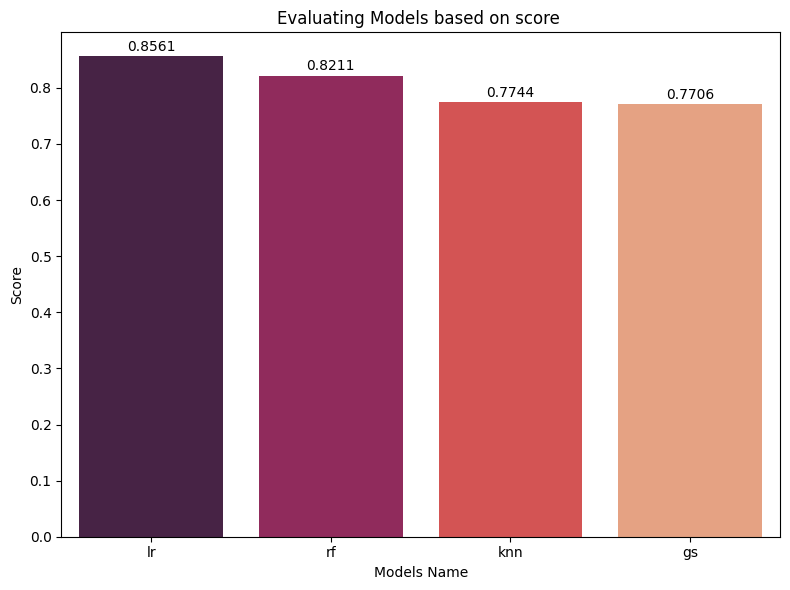

In [ ]:
# 計算模型的得分
score = get_score(y_pred_bert, y_test_bert)

# 創建包含模型名稱和分數的 DataFrame
md_scores = pd.DataFrame({'models': models_name_bert, 'score': score})

md_scores_sorted = md_scores.sort_values(by='score', ascending=False)

# 繪製柱狀圖，並將分數顯示在每個柱上
plt.figure(figsize=(8, 6))
bars = sns.barplot(x='models', y='score', data=md_scores_sorted, palette='rocket')

# 在每個柱上顯示分數（從已排序的 DataFrame 中讀取分數資料）
for bar, value in zip(bars.patches, md_scores_sorted['score']):
    bars.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, round(value, 4), ha='center', color='black', fontsize=10)

plt.title('Evaluating Models based on score ')
plt.xlabel('Models Name')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

In [ ]:
# 定義繪製混淆矩陣和分類報告的函數
def plot_evaluation_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')
    plt.show()
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

Evaluating Model: lr


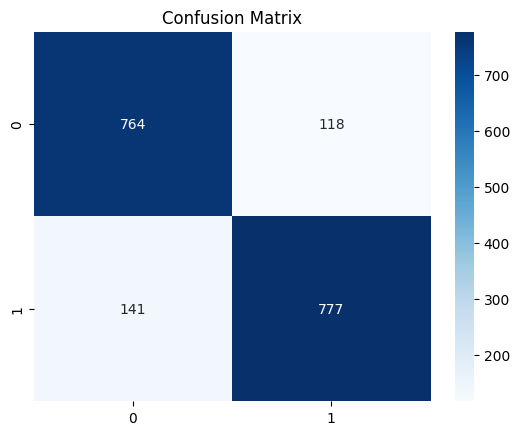

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       882
           1       0.87      0.85      0.86       918

    accuracy                           0.86      1800
   macro avg       0.86      0.86      0.86      1800
weighted avg       0.86      0.86      0.86      1800

Evaluating Model: rf


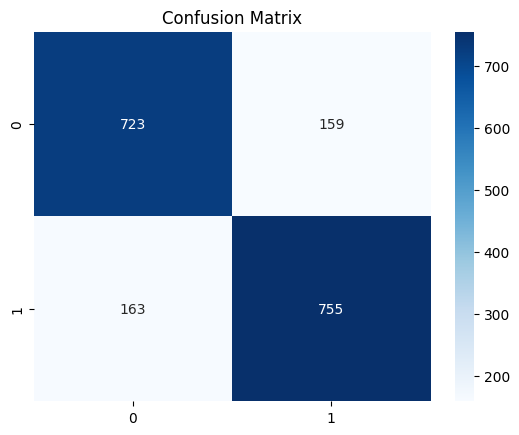

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       882
           1       0.83      0.82      0.82       918

    accuracy                           0.82      1800
   macro avg       0.82      0.82      0.82      1800
weighted avg       0.82      0.82      0.82      1800

Evaluating Model: gs


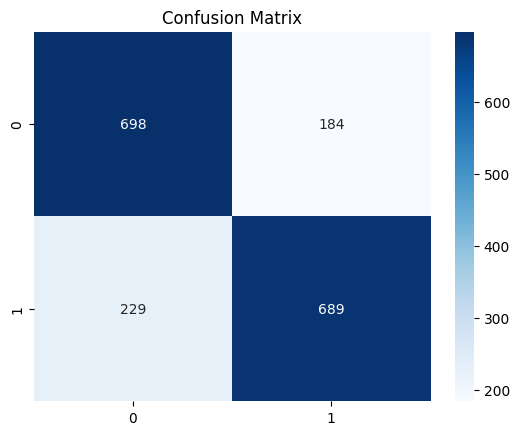

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       882
           1       0.79      0.75      0.77       918

    accuracy                           0.77      1800
   macro avg       0.77      0.77      0.77      1800
weighted avg       0.77      0.77      0.77      1800

Evaluating Model: knn


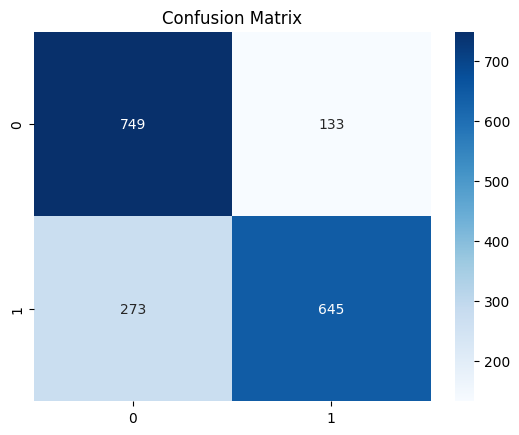

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.85      0.79       882
           1       0.83      0.70      0.76       918

    accuracy                           0.77      1800
   macro avg       0.78      0.78      0.77      1800
weighted avg       0.78      0.77      0.77      1800



In [ ]:
for model_name, model_obj in models.items():
    print(f"Evaluating Model: {model_name}")
    plot_evaluation_metrics(model_obj, X_test_bert, y_test_bert)